### Import thư viện cần dùng

In [30]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import spm1d
from hotelling.plots import control_chart, univariate_control_chart

### Hàm vẽ Ellipse

In [2]:
def get_cov_ellipse(cov, centre, nstd, eig = False, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    if eig:
        return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs), eigvals, eigvecs
    else: 
        return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

### Bài 5.20

Sử dụng bộ data bảng 5.12 về chim. Một nhà sinh vật học hoang dã đo $x_1$ là độ dài đuôi (theo milimét) và $x_2$ là độ dài cánh (theo milimet) cho một mẫu có kích cỡ 45.

In [3]:
print('Exercise 5.20: ')
print('a)')
path_512 = 'T5-12.txt'
data_512 = pd.read_table(path_512, delim_whitespace=True,header=None)
data_512.columns=['x_1(tail length)','x_2(wing length)']
print(data_512)
n_512,p_512=data_512.shape


Exercise 5.20: 
a)
    x_1(tail length)  x_2(wing length)
0                191               284
1                197               285
2                208               288
3                180               273
4                180               275
5                188               280
6                210               283
7                196               288
8                191               271
9                179               257
10               208               289
11               202               285
12               200               272
13               192               282
14               199               280
15               186               266
16               197               285
17               201               295
18               190               282
19               209               305
20               187               285
21               207               297
22               178               268
23               202               271
24    

### a) Vẽ miền ellipse tin cậy 95% cho trung bình tổng thể $\mu_1, \mu_2$. Giả sử biết $\mu_1=190mm, \mu_2=275mm$, đây có phải là những giá trị khả thi cho độ dài trung bình đuôi và cánh cho một con chim cái không ?

In [4]:
x_mean = data_512.mean(axis=0)
S = np.cov(data_512.T)
print(">> Vectơ trung bình mẫu: \n", np.array(x_mean))
print("\n>> Ma trận hiệp phương sai mẫu: \n", S)

alpha = 0.05
f_512 = stats.f.ppf(q=1-alpha, dfn=p_512, dfd=n_512-p_512)
F_512 = (p_512*(n_512-1)/(n_512-p_512))*f_512
print('\n>> Giá trị tới hạn là: \n',F_512)

>> Vectơ trung bình mẫu: 
 [193.62222222 279.77777778]

>> Ma trận hiệp phương sai mẫu: 
 [[120.69494949 122.3459596 ]
 [122.3459596  208.54040404]]

>> Giá trị tới hạn là: 
 6.5784713686908765


In [5]:
# Trị riêng và vectơ riêng của ma trận S
eigvals, eigvecs = np.linalg.eigh(S)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]
print(">> Các trị riêng của ma trận hiệp phương sai mẫu: \n", eigvals)
print("\n>> Các vectơ riêng của ma trận hiệp phương sai mẫu: \n", eigvecs)

nstd = np.sqrt(F_512/n_512)
# Chiều dài các trục của confidence ellipspoid
lengths = 2 * nstd * np.sqrt(eigvals)
print("\n>> Độ dài các trục của hình confidence ellipse: \n", lengths)

>> Các trị riêng của ma trận hiệp phương sai mẫu: 
 [294.6089834   34.62637013]

>> Các vectơ riêng của ma trận hiệp phương sai mẫu: 
 [[ 0.57537391 -0.8178905 ]
 [ 0.8178905   0.57537391]]

>> Độ dài các trục của hình confidence ellipse: 
 [13.12529961  4.49976379]


Text(0.5, 1.0, '\n>> Miền tin cậy hình ellip 95% cho trung bình tổng thể $ \\mu_1, \\mu_2 $ là:')

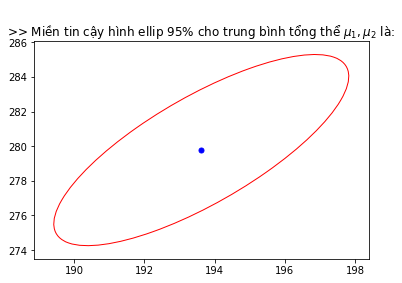

In [6]:
fig, ax = plt.subplots()
e = get_cov_ellipse(S, x_mean, np.sqrt(F_512/n_512), edgecolor='red', facecolor='None')
ax.scatter(x_mean[0], x_mean[1], c='blue', s=25)
ax.add_patch(e)
ax.set_title("\n>> Miền tin cậy hình ellip 95% cho trung bình tổng thể $ \mu_1, \mu_2 $ là:")

Điểm $(190,275)$ nằm trong hình ellipse nên ta kết luận đây là giá trị khả thi cho trung bình độ dài đuôi và độ dài cánh cho những con chim cái.

### b) Xây dựng khoảng $T^2$ đồng thời 95% cho $\mu_1, \mu_2$ và khoảng Bonferroni 95% cho $\mu_1,\mu_2$. So sánh hai khoảng này. Nêu sự thuận lợi mà khoảng $T^2$ có so với khoảng Bonferroni.

Với độ tin cậy 95%, ta có giá trị
<center> $\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)$ <center>
    
Từ đây, ta xây dựng được khoảng tin cậy 95% cho từng giá trị $\mu_1,\mu_2$ như sau
    
<center> $\overline{x}_1-\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{11}}{n}}\leq\mu_1\leq\overline{x}_1+\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{11}}{n}}$ <center>

<center> $\overline{x}_2-\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{22}}{n}}\leq\mu_2\leq\overline{x}_2+\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{22}}{n}}$ <center>

In [7]:
lcb = lambda i: x_mean[i] - np.sqrt(F_512)*np.sqrt(S[i][i]/n_512)
ucb = lambda i: x_mean[i] + np.sqrt(F_512)*np.sqrt(S[i][i]/n_512)

print("\n>> Khoảng T^2 95% cho trung bình: \n")
IC = []
for i in range(p_512):
    ic = [lcb(i), ucb(i)]
    print(">> {}:\t{}\n".format(data_512.columns[i], ic))
    IC.append(ic)


>> Khoảng T^2 95% cho trung bình: 

>> x_1(tail length):	[189.42172418403118, 197.8227202604133]

>> x_2(wing length):	[274.25635067321497, 285.2992048823406]



Với độ tin cậy 95%, ta xây dựng được khoảng tin cậy Bonferroni 95% cho từng giá trị $\mu_1, \mu_2$ như sau
    
<center> $\overline{x}_1-t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{11}}{n}}\leq\mu_1\leq\overline{x}_1+t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{11}}{n}}$ <center>
    
<center> $\overline{x}_2-t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{22}}{n}}\leq\mu_2\leq\overline{x}_2+t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{22}}{n}}$ <center>

In [8]:
t_512 = stats.t.ppf(1-(alpha/(2*p_512)), n_512-1)

lcb_bonfer = lambda i: x_mean[i] - t_512*np.sqrt(S[i][i]/n_512)
ucb_bonfer = lambda i: x_mean[i] + t_512*np.sqrt(S[i][i]/n_512)

print("Khoảng tin cậy 95% Bonferroni: \n")

IC_bonfer = []
for i in range(p_512):
    ic = [lcb_bonfer(i), ucb_bonfer(i)]
    print(">> {}:\t{}\n".format(data_512.columns[i], ic))
    IC_bonfer.append(ic)

Khoảng tin cậy 95% Bonferroni: 

>> x_1(tail length):	[189.82155966089658, 197.4228847835479]

>> x_2(wing length):	[274.7819222647878, 284.77363329076775]



Ta nhận thấy khoảng $T^2$ rộng hơn khoảng Bonferroni với cùng độ tin cậy. Do đó, khoảng $T^2$ sẽ nhận được nhiều giá trị cho trung bình đồng thời hơn khoảng Bonferroni.

### c) Mô hình tổng thể có tuân theo phân phối chuẩn 2 chiều không ? Giải thích với Q-Q plots và đồ thị phân tán

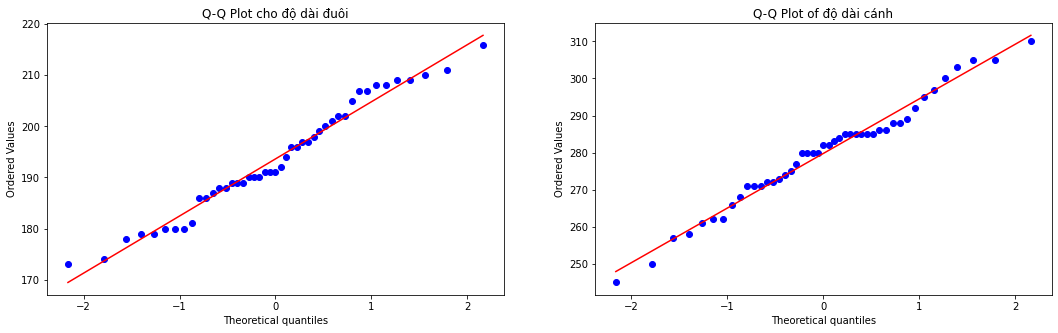

In [9]:
fig, axs = plt.subplots(1,2, figsize=(18,5))

qq_1 = stats.probplot(data_512['x_1(tail length)'], dist=stats.norm, plot=axs[0])
axs[0].set_title('Q-Q Plot cho độ dài đuôi')

qq_2 = stats.probplot(data_512['x_2(wing length)'], dist=stats.norm, plot=axs[1])
axs[1].set_title('Q-Q Plot of độ dài cánh')

plt.show()

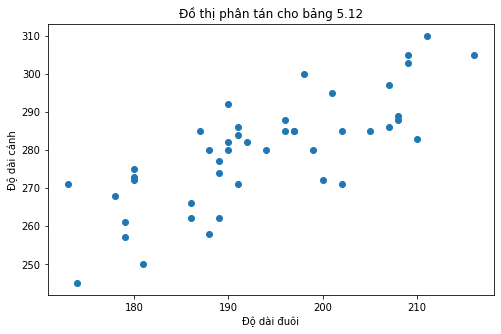

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(data_512['x_1(tail length)'], data_512['x_2(wing length)'])
ax.set(xlabel='Độ dài đuôi', ylabel='Độ dài cánh')
ax.set_title('Đồ thị phân tán cho bảng 5.12')
plt.show()

Từ cả 2 đồ thị, ta không có đủ dữ kiện để bác bỏ tính chuẩn 2 chiều. Vì các điểm của từng $x_1, x_2$ ở đồ trị Q-Q plot có xu hướng fit theo đường tuyến tính và đồ thị phân tán cũng không chỉ ra tính sai lệch với phân phối chuẩn 2 chiều.

### Bài 5.22

Một phần của dữ liệu ở bảng 6.10 được sử dụng lại cho bảng 5.13. Những dữ liệu này thể hiện mối quan hệ giá tiền với việc vận chuyển sữa từ nông trại tới nhà máy sữa bằng xe tải chạy bằng gas. Chỉ có 25 quan trắc nhiều chiều cho xe tải chạy bằng gas được cho. Quan trắc thứ 9 và 21 được xác định là điểm ngoại lai từ toàn bộ dữ liệu có 36 quan trắc. 

In [11]:
print('Exercise 5.22: ')
print('a)')
path_513 = 'T5-13.txt'
data_513 = pd.read_table(path_513, delim_whitespace=True,header=None)
data_513.columns=['Fuel(x_1)','Repair(x_2)','Capital(x_3)']
print(data_513)
n_513,p_513=data_513.shape

Exercise 5.22: 
a)
    Fuel(x_1)  Repair(x_2)  Capital(x_3)
0       16.44        12.43         11.23
1        7.19         2.70          3.92
2        9.92         1.35          9.75
3        4.24         5.78          7.78
4       11.20         5.05         10.67
5       14.25         5.78          9.88
6       13.50        10.98         10.60
7       13.32        14.27          9.45
8       29.11        15.09          3.28
9       12.68         7.61         10.23
10       7.51         5.80          8.13
11       9.90         3.63          9.13
12      10.25         5.07         10.17
13      11.11         6.15          7.61
14      12.17        14.26         14.39
15      10.24         2.59          6.09
16      10.18         6.05         12.14
17       8.88         2.70         12.23
18      12.34         7.73         11.68
19       8.51        14.02         12.01
20      26.16        17.44         16.89
21      12.95         8.24          7.18
22      16.93        13.37         17.

###a) Vẽ Q-Q plot về phân phối lề của fuel, repair và capital costs. Hơn nữa, hãy xây dựng 3 đồ thị phân tán cho từng cặp quan trắc của các biến khác nhau. Các điểm ngoại lai có rõ không ? Vẽ lại Q - Q plot và đồ thị phân tán với các điểm ngoại lai rõ ràng bị loại bỏ. Bộ dữ liệu bây giờ trông có tuân theo phân phối chuẩn không ?

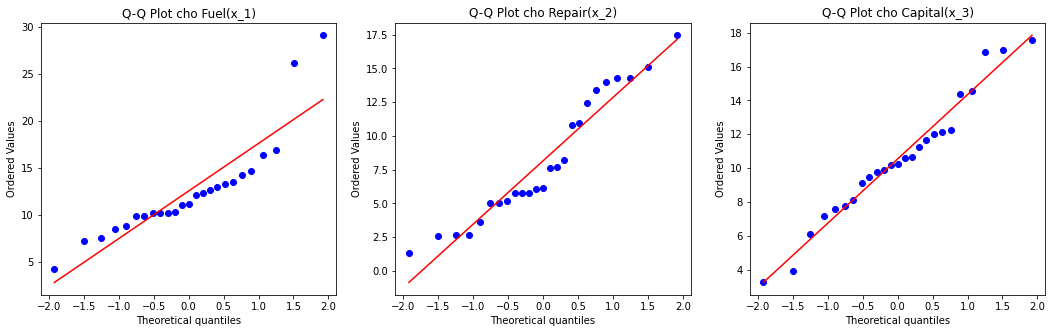

In [12]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

qq_1 = stats.probplot(data_513['Fuel(x_1)'], dist=stats.norm, plot=axs[0])
axs[0].set_title('Q-Q Plot cho Fuel(x_1)')

qq_2 = stats.probplot(data_513['Repair(x_2)'], dist=stats.norm, plot=axs[1])
axs[1].set_title('Q-Q Plot cho Repair(x_2)')

qq_3 = stats.probplot(data_513['Capital(x_3)'], dist=stats.norm, plot=axs[2])
axs[2].set_title('Q-Q Plot cho Capital(x_3)')

plt.show()

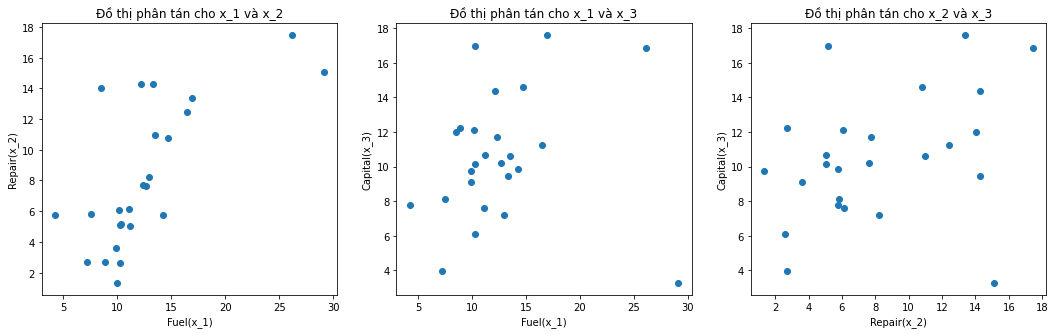

In [13]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(data_513['Fuel(x_1)'], data_513['Repair(x_2)'])
ax[0].set(xlabel='Fuel(x_1)', ylabel='Repair(x_2)')
ax[0].set_title('Đồ thị phân tán cho x_1 và x_2')

ax[1].scatter(data_513['Fuel(x_1)'], data_513['Capital(x_3)'])
ax[1].set(xlabel='Fuel(x_1)', ylabel='Capital(x_3)')
ax[1].set_title('Đồ thị phân tán cho x_1 và x_3')

ax[2].scatter(data_513['Repair(x_2)'], data_513['Capital(x_3)'])
ax[2].set(xlabel='Repair(x_2)', ylabel='Capital(x_3)')
ax[2].set_title('Đồ thị phân tán cho x_2 và x_3')

plt.show()

Các điểm ngoại lai trên đồ thị có thể nhìn ra dễ dàng. Chúng ta sẽ loại bỏ 2 điểm ngoại lai là $(29.11,15.09,3.28), (26.16,17.44,16.89)$

In [14]:
data_513_new=data_513.copy()
data_513_without_outlier=data_513_new.drop([8,20],axis=0)
print(data_513_without_outlier)

    Fuel(x_1)  Repair(x_2)  Capital(x_3)
0       16.44        12.43         11.23
1        7.19         2.70          3.92
2        9.92         1.35          9.75
3        4.24         5.78          7.78
4       11.20         5.05         10.67
5       14.25         5.78          9.88
6       13.50        10.98         10.60
7       13.32        14.27          9.45
9       12.68         7.61         10.23
10       7.51         5.80          8.13
11       9.90         3.63          9.13
12      10.25         5.07         10.17
13      11.11         6.15          7.61
14      12.17        14.26         14.39
15      10.24         2.59          6.09
16      10.18         6.05         12.14
17       8.88         2.70         12.23
18      12.34         7.73         11.68
19       8.51        14.02         12.01
21      12.95         8.24          7.18
22      16.93        13.37         17.59
23      14.70        10.78         14.58
24      10.32         5.16         17.00


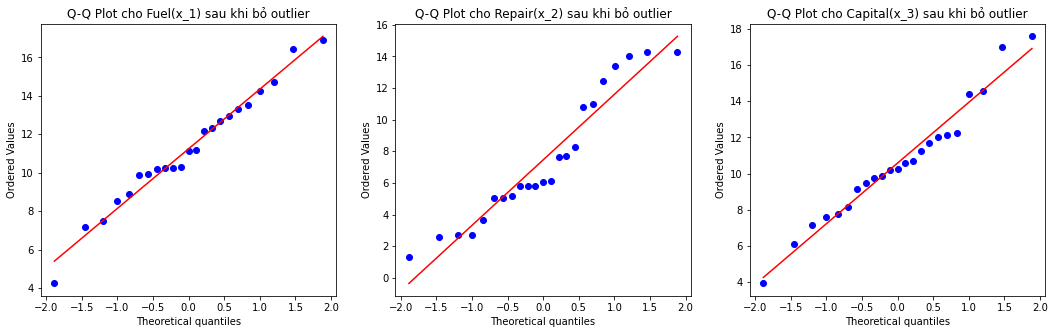

In [15]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

qq_1 = stats.probplot(data_513_without_outlier['Fuel(x_1)'], dist=stats.norm, plot=axs[0])
axs[0].set_title('Q-Q Plot cho Fuel(x_1) sau khi bỏ outlier')

qq_2 = stats.probplot(data_513_without_outlier['Repair(x_2)'], dist=stats.norm, plot=axs[1])
axs[1].set_title('Q-Q Plot cho Repair(x_2) sau khi bỏ outlier')

qq_3 = stats.probplot(data_513_without_outlier['Capital(x_3)'], dist=stats.norm, plot=axs[2])
axs[2].set_title('Q-Q Plot cho Capital(x_3) sau khi bỏ outlier')

plt.show()

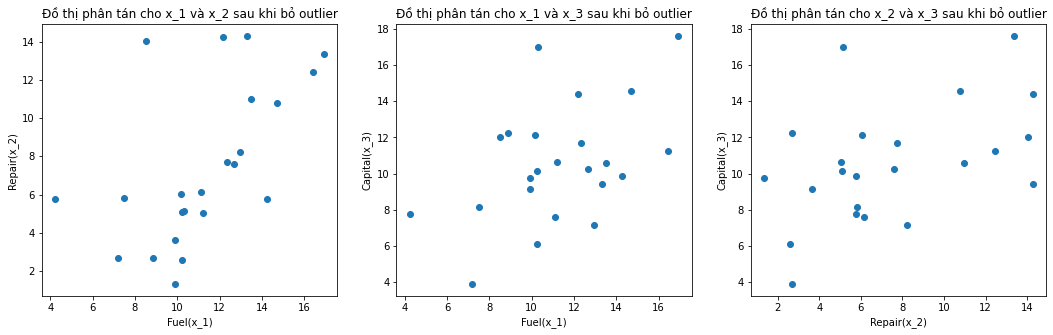

In [16]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(data_513_without_outlier['Fuel(x_1)'], data_513_without_outlier['Repair(x_2)'])
ax[0].set(xlabel='Fuel(x_1)', ylabel='Repair(x_2)')
ax[0].set_title('Đồ thị phân tán cho x_1 và x_2 sau khi bỏ outlier')

ax[1].scatter(data_513_without_outlier['Fuel(x_1)'], data_513_without_outlier['Capital(x_3)'])
ax[1].set(xlabel='Fuel(x_1)', ylabel='Capital(x_3)')
ax[1].set_title('Đồ thị phân tán cho x_1 và x_3 sau khi bỏ outlier')

ax[2].scatter(data_513_without_outlier['Repair(x_2)'], data_513_without_outlier['Capital(x_3)'])
ax[2].set(xlabel='Repair(x_2)', ylabel='Capital(x_3)')
ax[2].set_title('Đồ thị phân tán cho x_2 và x_3 sau khi bỏ outlier')

plt.show()

Sau khi loại bỏ điểm ngoại lai, bộ dữ liệu trông tuân theo phân phối chuẩn hơn. Ví dụ như đồ thị Q-Q plot, các điểm dữ liệu fit đường tuyến tính hơn là khi có điểm ngoại lai.

### b) Xây dựng khoảng Bonferroni 95% cho từng trung bình giá tiền riêng lẻ. Hơn nữa, hãy xây dựng khoảng $T^2$ 95%. So sánh hai khoảng trên.

In [17]:
x_mean = data_513.mean(axis=0)
S = np.cov(data_513.T)
print(">> Vectơ trung bình mẫu: \n", np.array(x_mean))
print("\n>> Ma trận hiệp phương sai mẫu: \n", S)

alpha = 0.05
f_513 = stats.f.ppf(q=1-alpha, dfn=p_513, dfd=n_513-p_513)
F_513 = (p_513*(n_513-1)/(n_513-p_513))*f_513
print('\n>> Giá trị tới hạn là: \n',F_513)

>> Vectơ trung bình mẫu: 
 [12.56    8.1612 10.5444]

>> Ma trận hiệp phương sai mẫu: 
 [[28.965925   17.21535833  2.69456667]
 [17.21535833 21.45285267  6.04452783]
 [ 2.69456667  6.04452783 13.59904233]]

>> Giá trị tới hạn là: 
 9.97895450831698


Với độ tin cậy 95%, ta có giá trị
<center> $\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)$ <center>
    
Từ đây, ta xây dựng được khoảng tin cậy 95% cho từng giá trị $\mu_1,\mu_2,\mu_3$ như sau
    
<center> $\overline{x}_1-\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{11}}{n}}\leq\mu_1\leq\overline{x}_1+\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{11}}{n}}$ <center>

<center> $\overline{x}_2-\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{22}}{n}}\leq\mu_2\leq\overline{x}_2+\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{22}}{n}}$ <center>

<center> $\overline{x}_3-\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{33}}{n}}\leq\mu_3\leq\overline{x}_3+\sqrt{\dfrac{p(n-1)}{n-p}F_{p,n-p}(\alpha)}\sqrt{\dfrac{s_{33}}{n}}$ <center>

In [18]:
lcb = lambda i: x_mean[i] - np.sqrt(F_513)*np.sqrt(S[i][i]/n_513)
ucb = lambda i: x_mean[i] + np.sqrt(F_513)*np.sqrt(S[i][i]/n_513)

print("\n>> Khoảng T^2 95% cho trung bình: \n")
IC = []
for i in range(p_513):
    ic = [lcb(i), ucb(i)]
    print(">> {}:\t{}\n".format(data_513.columns[i], ic))
    IC.append(ic)


>> Khoảng T^2 95% cho trung bình: 

>> Fuel(x_1):	[9.159707966269242, 15.96029203373076]

>> Repair(x_2):	[5.234925639422761, 11.087474360577241]

>> Capital(x_3):	[8.214556873941852, 12.87424312605815]



Với độ tin cậy 95%, ta xây dựng được khoảng tin cậy Bonferroni 95% cho từng giá trị $\mu_1, \mu_2, \mu_3$ như sau
    
<center> $\overline{x}_1-t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{11}}{n}}\leq\mu_1\leq\overline{x}_1+t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{11}}{n}}$ <center>
    
<center> $\overline{x}_2-t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{22}}{n}}\leq\mu_2\leq\overline{x}_2+t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{22}}{n}}$ <center>

<center> $\overline{x}_3-t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{33}}{n}}\leq\mu_3\leq\overline{x}_3+t_{n-1}\left(\dfrac{\alpha}{2p}\right)\sqrt{\dfrac{s_{33}}{n}}$ <center>

In [19]:
t_513 = stats.t.ppf(1-(alpha/(2*p_513)), n_513-1)

lcb_bonfer = lambda i: x_mean[i] - t_513*np.sqrt(S[i][i]/n_513)
ucb_bonfer = lambda i: x_mean[i] + t_513*np.sqrt(S[i][i]/n_513)

print("Khoảng tin cậy 95% Bonferroni: \n")

IC_bonfer = []
for i in range(p_513):
    ic = [lcb_bonfer(i), ucb_bonfer(i)]
    print(">> {}:\t{}\n".format(data_513.columns[i], ic))
    IC_bonfer.append(ic)

Khoảng tin cậy 95% Bonferroni: 

>> Fuel(x_1):	[9.789732761438135, 15.330267238561866]

>> Repair(x_2):	[5.777121835026541, 10.54527816497346]

>> Capital(x_3):	[8.646243012576223, 12.44255698742378]



Ta nhận thấy khoảng $T^2$ rộng hơn khoảng Bonferroni với cùng độ tin cậy.

###Bài 5.28

Là một phần của một nghiên cứu về quá trình dây chuyền làm các thanh sắt, một nhà máy sản xuất xe hơi sử dụng các sensor để ghi lại độ lệch của độ dày (milimét) 6 điểm khác nhau trên 1 chiếc xe hơi. 4 thông số đầu tiên được đo khi thân xe đã hoàn thành và 2 thông số cuối được đo khi phần thân dưới đang trong các giai đoạn dây chuyền trước đó. Dữ liệu của 50 chiếc xe được cho bởi bảng 5.14

In [20]:
print('Exercise 5.28: ')
print('a)')
path_514 = 'T5-14.txt'
data_514 = pd.read_table(path_514, delim_whitespace=True,header=None)
data_514.columns=['x_1','x_2','x_3','x_4','x_5','x_6']
print(data_514)
n_514,p_514=data_514.shape

Exercise 5.28: 
a)
     x_1   x_2   x_3   x_4   x_5   x_6
0  -0.12  0.36  0.40  0.25  1.37 -0.13
1  -0.60 -0.35  0.04 -0.28 -0.25 -0.15
2  -0.13  0.05  0.84  0.61  1.45  0.25
3  -0.46 -0.37  0.30  0.00 -0.12 -0.25
4  -0.46 -0.24  0.37  0.13  0.78 -0.15
5  -0.46 -0.16  0.07  0.10  1.15 -0.18
6  -0.46 -0.24  0.13  0.02  0.26 -0.20
7  -0.13  0.05 -0.01  0.09 -0.15 -0.18
8  -0.31 -0.16 -0.20  0.23  0.65  0.15
9  -0.37 -0.24  0.37  0.21  1.15  0.05
10 -1.08 -0.83 -0.81  0.05  0.21  0.00
11 -0.42 -0.30  0.37 -0.58  0.00 -0.45
12 -0.31  0.10 -0.24  0.24  0.65  0.35
13 -0.14  0.06  0.18 -0.50  1.25  0.05
14 -0.61 -0.35 -0.24  0.75  0.15 -0.20
15 -0.61 -0.30 -0.20 -0.21 -0.50 -0.25
16 -0.84 -0.35 -0.14 -0.22  1.65 -0.05
17 -0.96 -0.85  0.19 -0.18  1.00 -0.08
18 -0.90 -0.34 -0.78 -0.15  0.25  0.25
19 -0.46  0.36  0.24 -0.58  0.15  0.25
20 -0.90 -0.59  0.13  0.13  0.60 -0.08
21 -0.61 -0.50 -0.34 -0.58  0.95 -0.08
22 -0.61 -0.20 -0.58 -0.20  1.10  0.00
23 -0.46 -0.30 -0.10 -0.10  0.75 -0.10
24 -0.

###a) Quá trình sản xuất có vẻ ổn định ở 30 trường hợp đầu. Sử dụng những trường hợp này để ước lượng $S, \overline{x}$. Sau đó xây dựng biểu đổ $T^2$ sử dụng tất cả các biến bao gồm tất cả 50 trường hợp.

In [21]:
data_514_first=data_514.copy().loc[:29,:]
x_mean=np.mean(data_514_first, axis=0)
print('Trung bình ước lượng bởi 30 trường hợp đầu là: \n',np.array([x_mean]))

S=np.cov(data_514_first.T)
print('\nPhương sai mẫu ước lượng bởi 30 trường hợp đầu là: \n', S)

Trung bình ước lượng bởi 30 trường hợp đầu là: 
 [[-0.50633333 -0.207      -0.062      -0.03166667  0.698      -0.065     ]]

Phương sai mẫu ước lượng bởi 30 trường hợp đầu là: 
 [[ 0.06260333  0.06158517  0.04738345  0.00828218  0.01973862  0.00313966]
 [ 0.06158517  0.09244931  0.02677172 -0.0008431   0.02276483  0.01549138]
 [ 0.04738345  0.02677172  0.14461655  0.00784483  0.02109931 -0.0049069 ]
 [ 0.00828218 -0.0008431   0.00784483  0.10864885  0.02207241  0.0065569 ]
 [ 0.01973862  0.02276483  0.02109931  0.02207241  0.34284414  0.01458276]
 [ 0.00313966  0.01549138 -0.0049069   0.0065569   0.01458276  0.03660517]]


Đồ thị $T^2$ cho tất cả các biến của toàn bộ 50 trường hợp

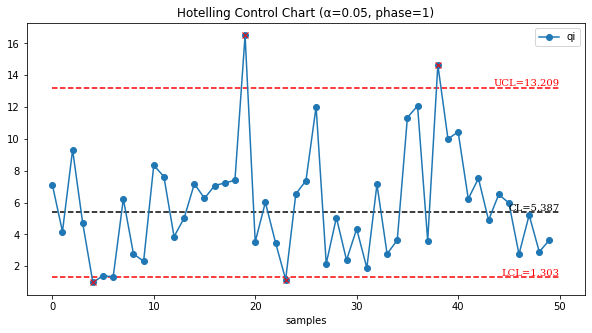

In [36]:
ax = control_chart(data_514, legend_right=True,alpha=0.05)

### b) Các địa điểm riêng lẻ nào có vẻ như cần xem xét ?

Các quan trắc nhiều chiều 4, 19, 23, 38 cần phải xem xét. Vì quan trắc 19, 38 lớn hơn giới hạn kiểm soát trên và quan trắc 4, 23 nhỏ hơn giới hạn kiểm soát dưới